In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # k-folding
from sklearn.model_selection import KFold
import sklearn.metrics
from scipy import stats
import json

2023-05-05 14:26:49.356053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import cactas as C

In [4]:
asymp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_no_norm.npy')
symp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_no_norm.npy')
asymp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_labels_no_norm.npy')
symp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_labels_no_norm.npy')

In [5]:
images = np.concatenate((asymp_img, symp_img, asymp_label, symp_label))
#images = np.concatenate((asymp_img, asymp_label, symp_img, symp_label))
labels = np.array([0]*len(asymp_img) + [0]*len(asymp_label) + [1]*len(symp_img) + [1]*len(symp_label))

In [6]:
train_f1 = []
test_f1 = []
train_acc = []
test_acc = []
confusion_matrices = []  # Store confusion matrices for each iteration
for i in range(10):
    X, y = shuffle(images, labels, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    #X_train, X_val, y_train, y_val = C.Util.split_2(X, y, val_size=0.10)
    
    X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_val_raveled = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
    
    # t~20
    #rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1) # Tweak THis
    # Comments below are to reduce overfitting, do the opposite if focusing on decreasing false positives
    rf = RandomForestClassifier(n_estimators=100, max_depth=5,          #5 Reduce max_depth
                             min_samples_split=10, # Increase min_samples_split
                             min_samples_leaf=1,   # Increase min_samples_leaf
                             #max_features='sqrt', # Lower threshold of max # of features used by each tree
                             random_state=42)
    
    # 5-fold cross-validation on the training data
    scores = cross_val_score(rf, X_train_raveled, y_train, cv=10, scoring='f1')
    scores_acc = cross_val_score(rf, X_train_raveled, y_train, cv=10, scoring='accuracy')
    k = 10
    kf = KFold(n_splits=k)
    fitted = rf.fit(X_train_raveled, y_train)
    y_pred = rf.predict(X_val_raveled)
    
    # Training acc, f1
    train_accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    f1 = sklearn.metrics.f1_score(y_val, y_pred)
    print('run', i, 'acc', train_accuracy, 'f1', f1)
    train_acc.append(train_accuracy)
    train_f1.append(f1)
    
    asymp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped.npy')
    symp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped.npy')
    asymp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_labels_cropped.npy')
    symp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_labels_cropped.npy')
    
    labels_test = np.array([0]*len(asymp_img_test) + [0]*len(asymp_label_test) + [1]*len(symp_img_test) + [1]*len(symp_label_test))
    images_test = np.concatenate((asymp_img_test, symp_img_test, asymp_label_test, symp_label_test))
    
    X_test, y_test = shuffle(images_test, labels_test, random_state=0)
    
    X_test_raveled = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
    
    y_pred = rf.predict(X_test_raveled)
    
    # Calculate the confusion matrix for the current iteration
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Testing acc, f1
    c_test_acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    c_test_f1 = sklearn.metrics.f1_score(y_test, y_pred)
    print('test run', i, 'acc', c_test_acc, 'f1', c_test_f1)
    
    
    test_acc.append(c_test_acc) # acc test
    test_f1.append(c_test_f1) # f1 test

# Calculate the average confusion matrix
avg_conf_matrix = np.mean(confusion_matrices, axis=0)

# Extract the counts of TP, TN, FP, and FN
tn, fp, fn, tp = avg_conf_matrix.ravel()

# Total samples for percentage
total_samples = tp + tn + fp + fn
print(total_samples)
tp_perc = (tp / total_samples) * 100
tn_perc = (tn / total_samples) * 100
fp_perc = (fp / total_samples) * 100
fn_perc = (fn / total_samples) * 100


# Print the mean and standard deviation of the cross-validation scores
print('Test F1 score:', test_f1)
print('Train F1 score:', train_f1)
print('Test acc score:', test_acc)
print('Train acc score:', train_acc)
print("Cross-validation F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Cross-validation acc score: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))

print(f"True Positives: {tp_perc:.2f}%")
print(f"True Negatives: {tn_perc:.2f}%")
print(f"False Positives: {fp_perc:.2f}%")
print(f"False Negatives: {fn_perc:.2f}%")



run 0 acc 0.9964726631393298 f1 0.9964912280701755
test run 0 acc 0.8535638673253352 f1 0.8715567935623646
run 1 acc 0.9929453262786596 f1 0.992831541218638
test run 1 acc 0.8415666901905434 f1 0.862480857580398
run 2 acc 0.9964726631393298 f1 0.996282527881041
test run 2 acc 0.8712067748764997 f1 0.8852562087393901
run 3 acc 0.9964726631393298 f1 0.9962264150943396
test run 3 acc 0.8436838390966831 f1 0.8640687327401043
run 4 acc 0.9964726631393298 f1 0.9965753424657535
test run 4 acc 0.8750882145377559 f1 0.8883280757097791
run 5 acc 0.9982363315696648 f1 0.998165137614679
test run 5 acc 0.8542695836273818 f1 0.8720966243419015
run 6 acc 0.9911816578483245 f1 0.9909584086799277
test run 6 acc 0.8560338743824982 f1 0.8734491315136477
run 7 acc 0.9947089947089947 f1 0.9950248756218906
test run 7 acc 0.8415666901905434 f1 0.862480857580398
run 8 acc 1.0 f1 1.0
test run 8 acc 0.8422724064925899 f1 0.8630095004596996
run 9 acc 0.9982363315696648 f1 0.9982425307557118
test run 9 acc 0.8645

In [7]:
def boxplot(all_data, labels, y_label='Time [s]', y_lim_min=0, y_lim=1000, title=None, outputdir='/home/thuytien.chu001/CACTAS/_EXPERIMENTS/', y_zoom=None):
    
    
    matplotlib.rcParams.update({'font.size': 32})
    plt.rc('axes', labelsize=65)    # fontsize of the x and y labels
    plt.rc('legend', fontsize=32)   
    plt.rc('xtick', labelsize=42) 

    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    fig = plt.figure(figsize=(7, 13))
    ax = fig.gca()
    # ax1 = plt.gcf()
    boxprops = dict(color="black",linewidth=1.5)
    medianprops = dict(color="black",linewidth=1.5)
    # rectangular box plot
    bplot1 = plt.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels,
                         boxprops=boxprops,
                         medianprops=medianprops)  # will be used to label x-ticks

    # fill with colors
    colors = ['#af8dc3', '#7fbf7b']
    # for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim_min,y_lim)
    # Set y-axis limits if y_zoom parameter is provided
    if y_zoom:
        ax.set_ylim(*y_zoom)

    titleb = title
    if not title:
        titleb = 'figure.pdf'



    filename_pdf = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.pdf'
    filename_png = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.png'
    plt.savefig(filename_pdf,bbox_inches='tight')
    plt.savefig(filename_png,bbox_inches='tight')

    if title:
        plt.title(title)


    plt.show()



    print(labels[0], np.mean(all_data[0]),'+/-', np.std(all_data[0]))
    print(labels[1], np.mean(all_data[1]),'+/-', np.std(all_data[1]))

    ttest = stats.ttest_ind(all_data[0],all_data[1])

    print('t_'+str(len(all_data[0]+all_data[1])), '=', str(round(ttest[0],3)), ',p=',str(round(ttest[1],2)))

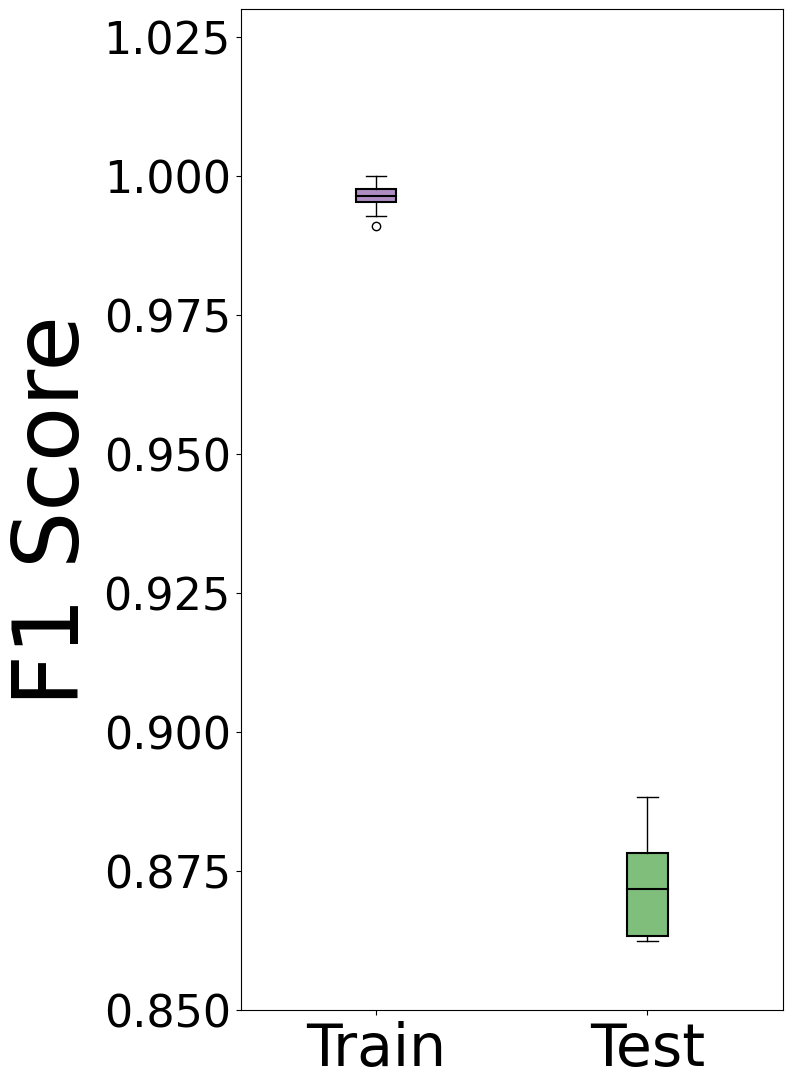

Train 0.9960798007402157 +/- 0.0025052771285500714
Test 0.8722726782227683 +/- 0.009126103056013905
t_20 = 39.247 ,p= 0.0


In [19]:
#f1 boxplot
data = [train_f1, test_f1]
labels = ['Train', 'Test']
C.Util.boxplot(data, labels, y_lim=1, y_label='F1 Score', outputdir='/home/thuytien.chu001/CACTAS/_EXPERIMENTS/', y_zoom=(0.85, 1.03))

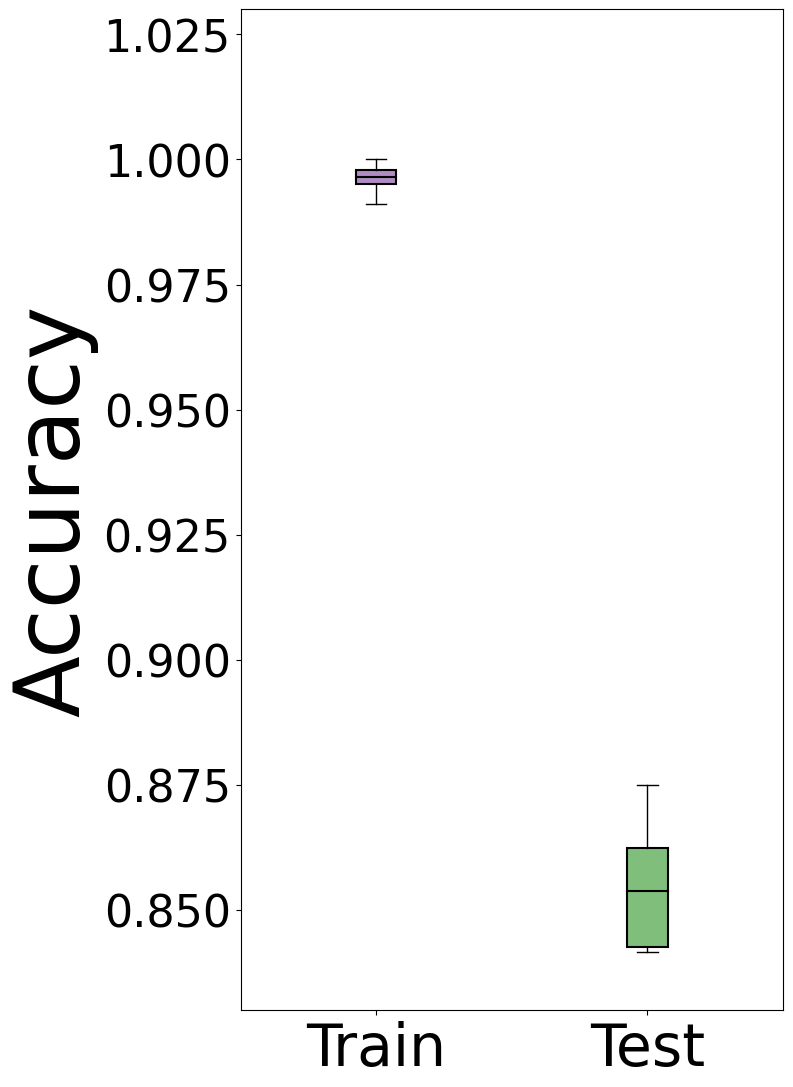

Train 0.9961199294532627 +/- 0.0024691358024691405
Test 0.8543754410726889 +/- 0.011862595640243962
t_20 = 35.094 ,p= 0.0


In [23]:
# acc boxplot
data = [train_acc, test_acc]
labels = ['Train', 'Test']
C.Util.boxplot(data, labels, y_lim=1, y_label='Accuracy', outputdir='/home/thuytien.chu001/CACTAS/_EXPERIMENTS/', y_zoom=(0.83,1.03))

In [10]:
#NOTES
# Some overfitting
# f1 variance of testing
# Identifies all pos cases, no false neg (great, most important), but false positives incorrectly idnetifying neg cases (asymp, ok)